<a href="https://colab.research.google.com/github/Komal7209/ServerTemperaturePredictionToBeShared/blob/main/CopyOfTempPrediction3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tqdm
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import datetime
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
!pip install wandb
import wandb

In [ ]:
#8. visualising the metrics
# could be weights and bias
# or generic pyplot
wandb.init(project = "LSTM")  # For creating new project at wanb website

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# 1. dataset creation (DataLoader , Generator)
class stockdataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, i):
        yield self.x[i], self.y[i]

    def __len__(self):
        return len(self.x)

NameError: ignored

In [ ]:
#2. lstm model
class Lstm(nn.Module):
    def __init__(self):
        super(Lstm, self).__init__()
        self.lstm1 = nn.LSTM(1,4,1) #input_size , n_hidden, n_layers
        self.h0 = torch.randn(1,1,4)
        self.c0 = torch.randn(1,1,4)

        self.l1 = nn.Linear(4,1) #hidden_nodes(from previous lstm layer), output_size #linear layer
        #self.l2 = nn.Linear(64,1)

    def forward(self, x):
        o1 = self.lstm1(x, (self.h0, self.c0))
        o2 = self.l1(o1[0])
        #return self.l2(o2)
        return o2

In [ ]:
#4.for converting timestamp to string
def datetime_to_string(dt):
    year, month, day, hour, minute, second = dt
    DT = datetime.datetime(int(year),int(month), int(day), int(hour), int(minute), int(second))
    DN = (DT - datetime.datetime(2000,1,1)).total_seconds()
    return float(repr(DN))

#5. normalising the input and labels
def normalise(data):
  normalized_dataset = (data - np.min(data)) / (np.max(data) - np.min(data))
  return normalized_dataset

if __name__ == '__main__':
    #3. getting the dataset with pandas
    dataset = pd.read_csv('ambient_temperature_system_failure.csv') #training_set
    x = dataset.iloc[:,0].values #inputs
    y = dataset.iloc[:,1].values #labels

    x = [i.split()[0].split("-") + i.split()[1].split(":") for i in x ]
    x = [datetime_to_string(i) for i in x]#timestamp

    x = normalise(np.array(x)) #normalised timestamp
    y = normalise(np.array(y)) #value

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [ ]:
#7. set up the metrics
# for performance of model
!pip install torchmetrics
from torchmetrics import CosineSimilarity, MeanAbsoluteError, MeanSquaredError

def get_metrics(output, y):
  mean_absolute_error = MeanAbsoluteError()
  mean_squared_error = MeanSquaredError()
  cosine_similarity = CosineSimilarity(reduction = 'mean')

  m1 = mean_absolute_error(output, y) #preds, target
  m2 = mean_squared_error(output, y)
  m3 = cosine_similarity(output, y)

  return {'mae':m1 ,'mse':m2, 'cs':m3}

In [ ]:
#6. Training of Model

#creating the dataset and dataloader with the inputs and labels
d1 = stockdataset(X_train,y_train)
d2 = stockdataset(X_test,y_test)

train_dataloader = DataLoader(d1, batch_size=128, shuffle=False)
test_dataloader = DataLoader(d2, batch_size=32, shuffle=False)

#calling the model, loss, optimizer
model = Lstm()
loss = nn.MSELoss()
optim = Adam(model.parameters(), lr=2e-3)

#hyperparameter
EPOCH = 10

loss_per_iter = []
#training loop
for i in tqdm.tqdm(range(EPOCH)):
    average_train_loss = 0.0
    for data in train_dataloader:
        x, y = data
        x = torch.unsqueeze(torch.unsqueeze(x, 1), 1).to(torch.float32)
        y = torch.unsqueeze(x, 1).to(torch.float32)
        y = torch.squeeze(y,3)
        output = model(x)
        optim.zero_grad()
        ls = loss(output, y)
        ls.backward()
        optim.step()
        l1 = get_metrics(output, y)
        average_train_loss += ls
    wandb.log(get_metrics(output, y))
    print(f'epoch {i}, loss: {average_train_loss/len(train_dataloader)}')
    loss_per_iter.append(average_train_loss.detach().numpy()/len(train_dataloader))

 10%|█         | 1/10 [00:01<00:09,  1.06s/it]

epoch 0, loss: 0.12825533747673035


 20%|██        | 2/10 [00:02<00:08,  1.06s/it]

epoch 1, loss: 0.0799403041601181


 30%|███       | 3/10 [00:03<00:07,  1.06s/it]

epoch 2, loss: 0.07470548152923584


 40%|████      | 4/10 [00:04<00:06,  1.04s/it]

epoch 3, loss: 0.06989338248968124


 50%|█████     | 5/10 [00:05<00:05,  1.04s/it]

epoch 4, loss: 0.0648239403963089


 60%|██████    | 6/10 [00:06<00:04,  1.03s/it]

epoch 5, loss: 0.05924386531114578


 70%|███████   | 7/10 [00:07<00:03,  1.03s/it]

epoch 6, loss: 0.05290336534380913


 80%|████████  | 8/10 [00:08<00:02,  1.03s/it]

epoch 7, loss: 0.04545524716377258


 90%|█████████ | 9/10 [00:09<00:01,  1.04s/it]

epoch 8, loss: 0.0363486222922802


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]

epoch 9, loss: 0.025527717545628548


In [ ]:
#Dont need to run again
#Save Model
!mkdir TempModel2
torch.save(model.state_dict(), 'TempModel2/model.pt')

#Dont need to run again
#Load Model
model2 = Lstm()
model2.load_state_dict(torch.load('TempModel2/model.pt'))
model2.eval() #here input would be given

Lstm(
  (lstm1): LSTM(1, 4)
  (l1): Linear(in_features=4, out_features=1, bias=True)
)

test loss:  tensor(0.0219, grad_fn=<DivBackward0>)


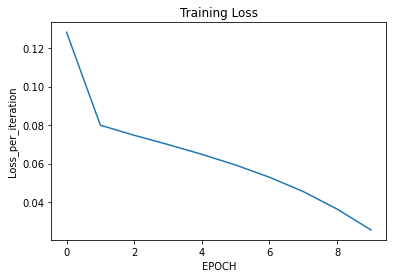

torch.Size([16, 1])
torch.Size([16, 4])
torch.Size([16])
torch.Size([16])
torch.Size([1, 4])
torch.Size([1])


In [ ]:
""" test loop """

model.eval()
total_test_loss = 0.0
for data in test_dataloader:
    x, y = data
    x = torch.unsqueeze(torch.unsqueeze(x, 1), 1).to(torch.float32)
    y = torch.unsqueeze(x, 1).to(torch.float32)
    y = torch.squeeze(y,3)
    output = model(x)
    total_test_loss += loss(output, y)

print("test loss: ", total_test_loss/len(test_dataloader))
plt.plot([i for i in range(EPOCH)], loss_per_iter)
plt.xlabel('EPOCH')
plt.ylabel('Loss_per_iteration')
plt.title('Training Loss')
# plt.legend()
plt.show()


# model parameter
for i in model.parameters():
    print(i.shape)

# hyperparamter optimise